迁移学习我们可以将已经学到的模型参数通过某种方式来分享给新模型从而加快并优化模型的学习效率不用像大多数模型那样从零学习，或者是利用数据之间的相似性对一些小样本数据进行扩充，以达到增加样本量的效果，进而提高模型的泛化性和预测能力。

迁移学习的域（Domain）表示学习的主体，表达了数据的特征以及特征的分布。域分为目标域（Target Domain）和源领域（Source Domain），目标域指的是要进行学习的域，源领域指的是已有知识的域。而任务（Task）由目标函数和学习结果组成，是学习的结果。

迁移学习可以分为基于实例、基于特征、基于模型、基于关系的迁移学习，在这四类迁移学习中，实例迁移比较容易实现，而且迁移的知识量最大，应用广泛。

TrAdaboost 是对每个样本增加权重，利用权重来弱化那些不同分布的测试集数据，进而提高模型的效果。
在每一次的迭代训练中，如果模型误分类了一个源域样本，那么这个样本可能和目标域样本具有较大的差距，因此需要降低这个样本的权重。通过给该样本乘一个 0 到 1 之间的权重，通过权重值的影响，在下一次的迭代中，这个样本对分类模型的影响就会降低，通过一系列的迭代之后，源域域中与目标域相似的或者说对目标域分类有帮助的样本的权重就会提高，而其他的源域的权重会降低。

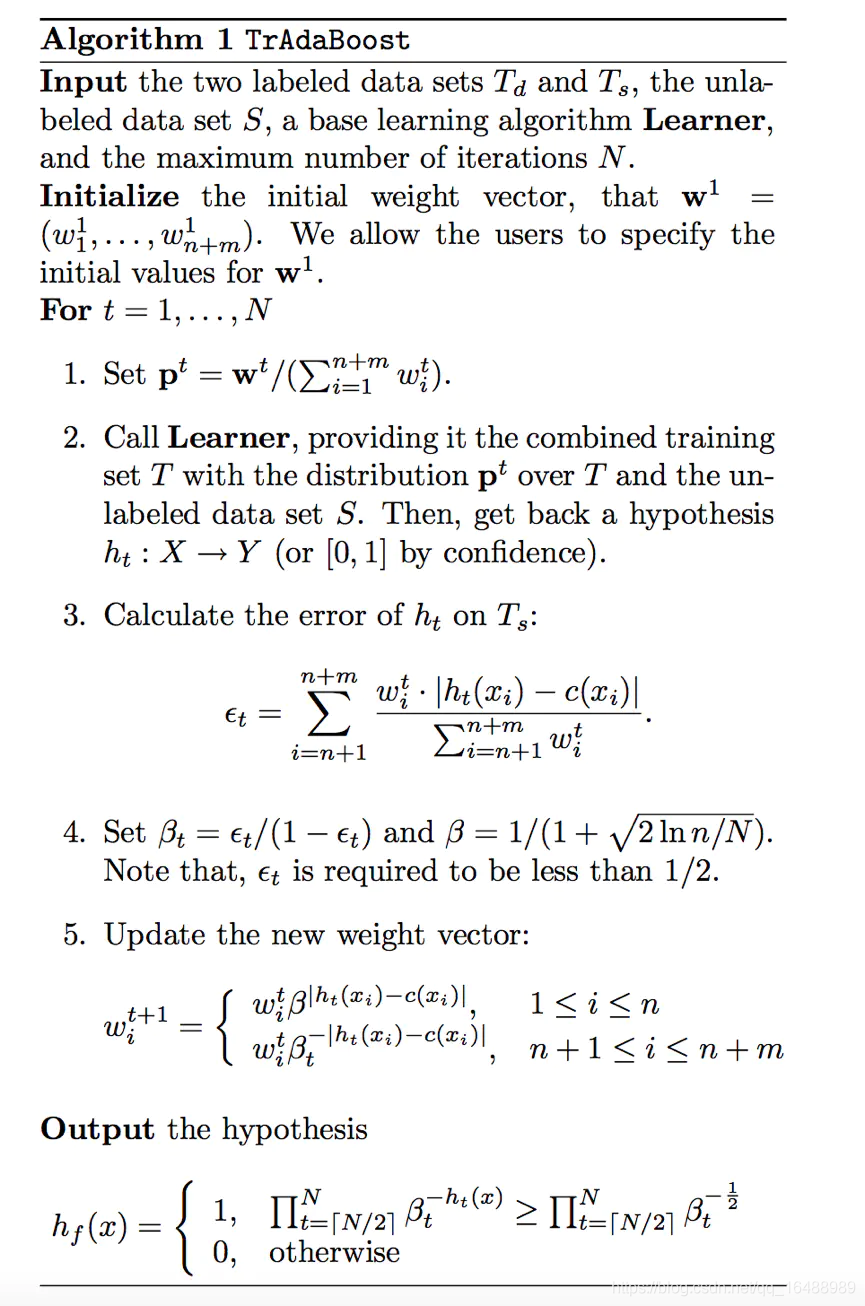

In [12]:
from IPython.display import Image
Image(filename='C:/Users/SHBFC-LX/Downloads/20201016100737746.png',width=500)

1. 初始化权重
2. fit模型，计算在目标域上的错误率, 并根据权重调整判断阈值
3. 权重调整方向：target样本权重(错分样本权重变大)，source样本权重,错分样本权重变小
4. 迭代训练
5. 最后一半的分类器投票产生结果

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
import xgboost as xgb
import numpy as np
import pandas as pd
import copy

import warnings
warnings.filterwarnings('ignore')
import os
import gc
os.chdir(r'C:\Users\SHBFC-LX\Downloads')
gc.collect()

# 样本数据读入
train_A = pd.read_csv('A_train.csv')
train_B = pd.read_csv('B_train.csv')
test = pd.read_csv('B_test.csv')
# sample = pd.read_csv('submit_sample.csv')

flag_A = train_A['flag']
train_A.drop('no', axis=1, inplace=True)
train_A.drop('flag', axis=1, inplace=True)
flag_B = train_B['flag']
train_B.drop('no', axis=1, inplace=True)
train_B.drop('flag', axis=1, inplace=True)

# 特征处理,筛选出非空占比高于1%的特征
info = train_B.describe()
useful_col = []
for col in info.columns:
    if info.loc['count',col] > train_B.shape[0]*0.01:
        useful_col.append(col)
train_B = train_B[useful_col]
train_A = train_A[useful_col]

In [2]:
class TrAdaboost:
    def __init__(self, base_classifier=DecisionTreeClassifier(), N=10, w_source=0.5, predict_p=0.5, score=roc_auc_score):
        self.base_classifier = base_classifier
        self.N = N
        self.w_source = w_source    #初始化的源域权重占比
        self.predict_p = predict_p   #用于预测最终结果的弱分类器占比
        self.score = score
        self.beta_T = np.zeros(self.N)
        self.threshold = None
        self.classifiers = []
        self.best_round = None    #最优分类器编号

    # 更新权重        
    def _calculate_weight(self, weights):
        sum_weight = np.sum(weights)
        shape = weights.shape[0]
        new_weights = np.asarray(weights / sum_weight * shape, order='C')
        return new_weights

    # 计算含权错误率
    def _calculate_error_rate(self, y_target, y_predict, weight_target):
        sum_weight = np.sum(weight_target)
        return np.sum(weight_target * np.abs(y_target - y_predict) / sum_weight)

    def fit(self, x_source, x_target, y_source, y_target, early_stopping_rounds=None, weights_all=False):
        x_train = np.concatenate((x_source, x_target), axis=0)
        y_train = np.concatenate((y_source, y_target), axis=0)
        x_train = np.asarray(x_train, order='C')
        y_train = np.asarray(y_train, order='C')
        y_source = np.asarray(y_source, order='C')
        y_target = np.asarray(y_target, order='C')
        
        row_source = x_source.shape[0]
        row_target = x_target.shape[0]
        self.threshold = np.sum(y_target) / row_target
        
        # 初始化权重(调整源域和目标域权重占比)
        weight_source = np.ones(row_source) / row_source * self.w_source
        weight_target = np.ones(row_target) / row_target * (1 - self.w_source)
        weights = np.concatenate((weight_source, weight_target), axis=0)

        beta = 1 / (1 + np.sqrt(2 * np.log(row_source / self.N)))


        result = np.ones([row_source + row_target, self.N])
        y_pred = np.zeros([row_target, self.N])
        score = np.zeros(self.N)
        count = 0
        
        for i in range(self.N):
            weights = self._calculate_weight(weights)
            self.base_classifier.fit(x_train, y_train, sample_weight=weights)
            self.classifiers.append(copy.deepcopy(self.base_classifier))
            result[:, i] = self.base_classifier.predict_proba(x_train)[:,1]
            
            #注意，仅仅计算在目标域上的错误率, 并根据权重调整判断阈值
            y_pred[:,i] = (result[row_source:, i] > self.threshold).astype(int)
            error_rate = self._calculate_error_rate(y_target, y_pred[:, i], weights[row_source:])
            print("Error Rate in target data:", round(error_rate,3), 'round:', i)
            
            # 若早停参数stopping_rounds不为None, 则当score连续减小参数次, 触发早停
            score[i] = self.score(y_target, result[row_source:, i])
            print("Score is:", round(score[i],3))
            if isinstance(early_stopping_rounds, int) and i>0:  #第一轮不更新count
                if round(score[i],3) < round(score[i-1],3):
                    count += 1 
                else:
                    count = 0
                    self.best_round = i+1
                if count >= early_stopping_rounds:
                    self.N = i+1
                    print("Score not improve, early stop at %d rounds" %i)
                    break
                
            # error_rate<=0.5才能保证beta_T<=1; error_rate越小,beta_T的倒数越大,错分样本权重变化越大
            if error_rate > 0.5:
                self.beta_T[i] = 1
            elif error_rate == 0:
                self.N = i+1
                print("Error Rate is zero, early stop at %d rounds" %i)
                break
            else:
                self.beta_T[i] = error_rate / (1 - error_rate)
                
            # 调整target样本权重,错分样本权重变大(正确样本权重不变)(默认不调整)
            if weights_all:
                for t in range(row_target):
                    weights[row_source + t] = weights[row_source + t] * np.power(self.beta_T[i], -np.abs(result[row_source + t, i] - y_target[t]))
            # 调整source样本权重,错分样本权重变小(正确样本权重不变)
            for s in range(row_source):
                weights[s] = weights[s] * np.power(beta, np.abs(result[s, i] - y_source[s]))

    def predict(self, x_test):
        result = np.ones([x_test.shape[0], self.N])

        for i,classifier in enumerate(self.classifiers):
            y_prob = classifier.predict_proba(x_test)[:,1]
            y_pred = (y_prob > self.threshold).astype(int)
            result[:, i] = y_pred

        start = int(np.floor((1 - self.predict_p) * self.N))
        predict = np.sum(result[:,start:],axis=1) / (self.N - start)
        predict = np.array([round(x,0) for x in predict])
                
        return predict
    

    def predict_proba(self, x_test):
        result = np.ones([x_test.shape[0], self.N])
        predict = np.zeros([x_test.shape[0], 2])

        for i,classifier in enumerate(self.classifiers):
            y_prob = classifier.predict_proba(x_test)[:,0]
            result[:, i] = y_prob
            
        start = int(np.floor((1 - self.predict_p) * self.N))
        predict[:, 0] = np.sum(result[:,start:],axis=1) / (self.N - start)
        predict[:, 1] = 1 - predict[:, 0]
            
        return predict
        

In [3]:
#baseline 模型
params = {'booster':'gbtree',
          'eta':0.1,
          'max_depth':3,
          'max_delta_step':0,
          'subsample':1,
          'colsample_bytree':1,
          # 'scale_pos_weight':scale_pos_weight,
          'objective':'binary:logistic',
          'lambda':3,
          'alpha':8,
          'n_estimators':100,
          'seed':100,
          'n_jobs':-1}


train_B_valid,train_B_test,flag_B_valid,flag_B_test = train_test_split(train_B,flag_B,test_size=0.5)

train = pd.concat([train_A, train_B_valid])
flag = pd.concat([flag_A, flag_B_valid])
clf = xgb.XGBClassifier(**params)
clf.fit(train, flag)

pred_A = clf.predict_proba(train_A)[:,1]
pred_B_valid = clf.predict_proba(train_B_valid)[:,1]
pred_B_test = clf.predict_proba(train_B_test)[:,1]
print(f" train AUC = {roc_auc_score(flag_A,pred_A)}")
print(f" valid AUC = {roc_auc_score(flag_B_valid,pred_B_valid)}")
print(f" test AUC = {roc_auc_score(flag_B_test,pred_B_test)}")

 train AUC = 0.7736356604854082
 valid AUC = 0.5817556380350305
 test AUC = 0.555338260466158


In [4]:
clf2 = TrAdaboost(base_classifier=xgb.XGBClassifier(**params), N=50)
clf2.fit(train_A, train_B_valid, flag_A, flag_B_valid, early_stopping_rounds=1)
pred_A2 = clf2.predict_proba(train_A)[:,1]
pred_B_valid2 = clf2.predict_proba(train_B_valid)[:,1]
pred_B_test2 = clf2.predict_proba(train_B_test)[:,1]
print(f" train AUC = {roc_auc_score(flag_A,pred_A2)}")
print(f" valid AUC = {roc_auc_score(flag_B_valid,pred_B_valid2)}")
print(f" test AUC = {roc_auc_score(flag_B_test,pred_B_test2)}")

Error Rate in target data: 0.521 round: 0
Score is: 0.795
Error Rate in target data: 0.318 round: 1
Score is: 0.824
Error Rate in target data: 0.301 round: 2
Score is: 0.848
Error Rate in target data: 0.303 round: 3
Score is: 0.852
Error Rate in target data: 0.401 round: 4
Score is: 0.846
Score not improve, early stop at 4 rounds
 train AUC = 0.6113261207402987
 valid AUC = 0.8548318409932781
 test AUC = 0.5949692854057687


In [5]:
for i,estimator in enumerate(clf2.classifiers):
    print('The '+str(i+1)+' estimator:')
    pred_A = estimator.predict_proba(train_A)[:,1]
    pred_B_valid = estimator.predict_proba(train_B_valid)[:,1]
    pred_B_test = estimator.predict_proba(train_B_test)[:,1]
    print(f" train AUC = {roc_auc_score(flag_A,pred_A)}")
    print(f" valid AUC = {roc_auc_score(flag_B_valid,pred_B_valid)}")
    print(f" test AUC = {roc_auc_score(flag_B_test,pred_B_test)}")

The 1 estimator:
 train AUC = 0.7421090222671367
 valid AUC = 0.7952887577049168
 test AUC = 0.5892082993393163
The 2 estimator:
 train AUC = 0.7210648277379812
 valid AUC = 0.8242287740784386
 test AUC = 0.5875465917998433
The 3 estimator:
 train AUC = 0.6557039246245533
 valid AUC = 0.8479850655858674
 test AUC = 0.5854689574634865
The 4 estimator:
 train AUC = 0.564226395007255
 valid AUC = 0.8519371051172763
 test AUC = 0.5936515173329494
The 5 estimator:
 train AUC = 0.5170386374150622
 valid AUC = 0.8463330286242938
 test AUC = 0.5936135240197726
